In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = '/content/drive/My Drive/Student Paper/Masud Rana/Dataset'


In [ ]:
# prompt: how many classes are there

import os

num_classes = len(os.listdir(dataset_dir))
print(f"Number of classes: {num_classes}")


Number of classes: 10


In [ ]:
# prompt: How many data are are in each class

import os

class_counts = {}
for class_name in os.listdir(dataset_dir):
  class_path = os.path.join(dataset_dir, class_name)
  if os.path.isdir(class_path):
    num_files = len(os.listdir(class_path))
    class_counts[class_name] = num_files

for class_name, count in class_counts.items():
  print(f"Class '{class_name}' has {count} data.")


Class 'Avulsion fracture' has 123 data.
Class 'Comminuted fracture' has 148 data.
Class 'Fracture Dislocation' has 156 data.
Class 'Greenstick fracture' has 121 data.
Class 'Hairline Fracture' has 109 data.
Class 'Impacted fracture' has 84 data.
Class 'Longitudinal fracture' has 78 data.
Class 'Oblique fracture' has 82 data.
Class 'Pathological fracture' has 129 data.
Class 'Spiral Fracture' has 86 data.


In [ ]:
# prompt: how many total data are there?

total_data = sum(class_counts.values())
print(f"Total number of data: {total_data}")


Total number of data: 1116


In [ ]:
# prompt: apply preprocessing on the dataset

import cv2
import numpy as np
from tqdm import tqdm

def preprocess_image(image_path, target_size=(64, 64)):
  """
  Applies preprocessing to an image.

  Args:
    image_path: Path to the image file.
    target_size: Desired size of the output image.

  Returns:
    Preprocessed image as a NumPy array.
  """
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, target_size)
  img = img / 255.0  # Normalize pixel values to [0, 1]
  return img

preprocessed_data = []
labels = []

for class_name in tqdm(os.listdir(dataset_dir)):
  class_path = os.path.join(dataset_dir, class_name)
  if os.path.isdir(class_path):
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      try:
        preprocessed_img = preprocess_image(image_path)
        preprocessed_data.append(preprocessed_img)
        labels.append(class_name)
      except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Convert lists to NumPy arrays
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)

print("Preprocessing complete.")
print(f"Shape of preprocessed data: {preprocessed_data.shape}")
print(f"Shape of labels: {labels.shape}")


100%|██████████| 10/10 [02:12<00:00, 13.28s/it]

Preprocessing complete.
Shape of preprocessed data: (1116, 64, 64, 3)
Shape of labels: (1116,)


In [ ]:
# prompt: apply augmentation and make 500 images in each class

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_data = []
augmented_labels = []

class_image_counts = defaultdict(int)

for i in tqdm(range(len(preprocessed_data))):
  image = preprocessed_data[i]
  label = labels[i]

  if class_image_counts[label] < 500:
    image = image.reshape((1,) + image.shape)  # Reshape for ImageDataGenerator
    for batch in datagen.flow(image, batch_size=1):
      augmented_data.append(batch[0])
      augmented_labels.append(label)
      class_image_counts[label] += 1
      if class_image_counts[label] >= 500:
        break

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

print("Augmentation complete.")
print(f"Shape of augmented data: {augmented_data.shape}")
print(f"Shape of augmented labels: {augmented_labels.shape}")


100%|██████████| 1116/1116 [00:08<00:00, 126.34it/s]

Augmentation complete.
Shape of augmented data: (5000, 64, 64, 3)
Shape of augmented labels: (5000,)


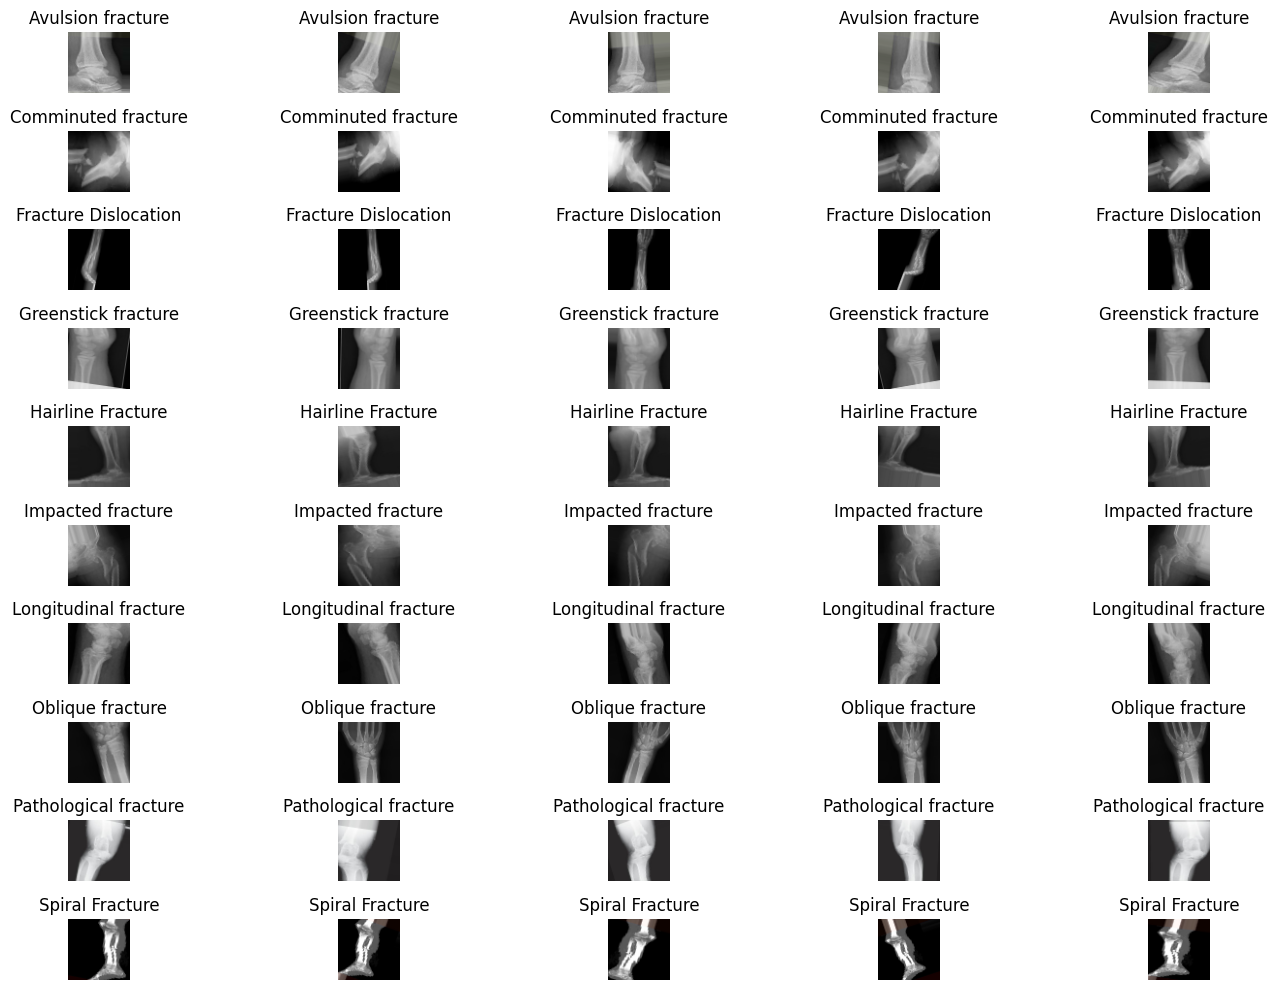

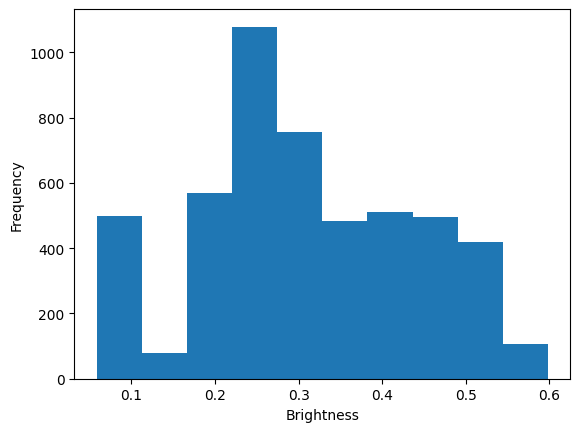

In [ ]:
# prompt: plot visualization graphs for augmented data

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have augmented_data and augmented_labels defined

# Function to plot a grid of images
def plot_images(images, labels, class_names, num_images_per_class=5):
  plt.figure(figsize=(15, 10))
  for i, class_name in enumerate(class_names):
    class_indices = [j for j, label in enumerate(labels) if label == class_name]
    for k in range(min(num_images_per_class, len(class_indices))):
      plt.subplot(len(class_names), num_images_per_class, i * num_images_per_class + k + 1)
      plt.imshow(images[class_indices[k]])
      plt.title(class_name)
      plt.axis('off')
  plt.tight_layout()
  plt.show()

# Get unique class names
unique_labels = np.unique(augmented_labels)

# Plot some augmented images for each class
plot_images(augmented_data, augmented_labels, unique_labels)

# You can also plot histograms of image properties like brightness, color, etc.
# For example, to plot a histogram of brightness:
brightness_values = [np.mean(image) for image in augmented_data]
plt.hist(brightness_values)
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()


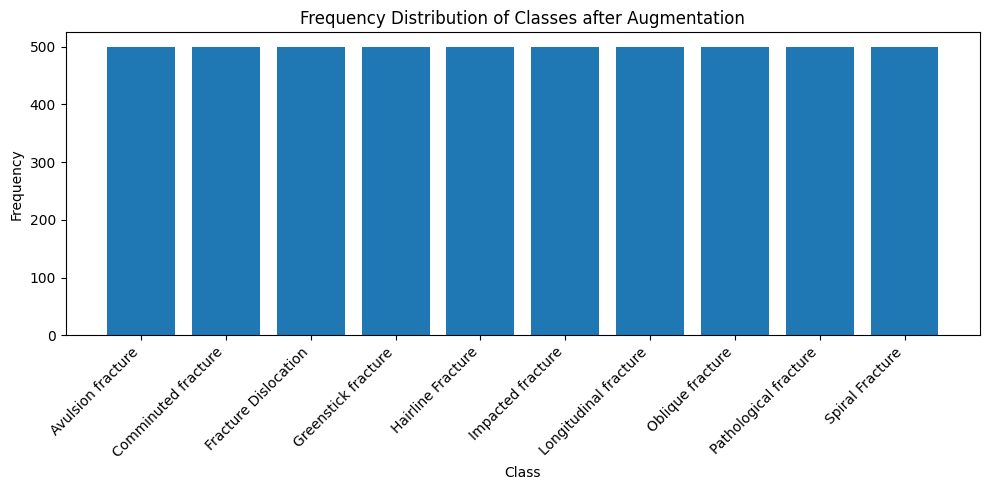

In [ ]:
# prompt: visualize the frequency distribution of in class after augmentation

import matplotlib.pyplot as plt
from collections import Counter

# Count the frequency of each class in the augmented labels
class_counts_augmented = Counter(augmented_labels)

# Create a bar chart to visualize the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts_augmented.keys(), class_counts_augmented.values())
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Classes after Augmentation")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
# prompt: Split dataset for model training

from sklearn.model_selection import train_test_split

# Split the augmented data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    augmented_data, augmented_labels, test_size=0.3, random_state=42, stratify=augmented_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training data shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, labels shape: {y_test.shape}")


Training data shape: (3500, 64, 64, 3), labels shape: (3500,)
Validation data shape: (750, 64, 64, 3), labels shape: (750,)
Testing data shape: (750, 64, 64, 3), labels shape: (750,)


In [ ]:
# prompt: train model with MobileNetV2 using colab's GPU

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded vectors
# Get unique class names and assign integer labels
unique_labels = np.unique(augmented_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Convert string labels to integer indices
y_train_encoded = to_categorical([label_to_index[label] for label in y_train], num_classes=len(unique_labels))
y_val_encoded = to_categorical([label_to_index[label] for label in y_val], num_classes=len(unique_labels))
y_test_encoded = to_categorical([label_to_index[label] for label in y_test], num_classes=len(unique_labels))

# Load the pre-trained MobileNetV2 model (excluding the top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3)) # Change input shape to (64, 64, 3)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Modify the output layer to match the number of classes
predictions = Dense(len(unique_labels), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
  layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val, y_val_encoded))

# Unfreeze some layers for fine-tuning (optional)
for layer in model.layers[:100]:
  layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(X_train, y_train_encoded, batch_size=32, epochs=5, validation_data=(X_val, y_val_encoded))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")


<ipython-input-12-b1811f5d13f6>:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3)) # Change input shape to (64, 64, 3)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.8991 - loss: 0.3351 - val_accuracy: 0.9973 - val_loss: 0.0195
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 1.0000 - loss: 5.3376e-04 - val_accuracy: 1.0000 - val_loss: 8.9106e-04
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 1.0000 - loss: 1.9273e-04 - val_accuracy: 1.0000 - val_loss: 7.8271e-04
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 1.0000 - loss: 1.2628e-04 - val_accuracy: 1.0000 - val_loss: 7.1280e-04
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 9.5906e-05 - val_accuracy: 1.0000 - val_loss: 6.4786e-04
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 7.5431e-05 - val_accuracy: 1.0000 - val_loss: 6.7077e-04
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s

In [ ]:
# prompt: generate the classification report

import numpy as np
from sklearn.metrics import classification_report

# Get predicted probabilities for the test set
y_pred_probs = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=unique_labels)

print(report)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       1.00      0.99      0.99        75
  Comminuted fracture       1.00      0.95      0.97        75
 Fracture Dislocation       1.00      1.00      1.00        75
  Greenstick fracture       1.00      0.97      0.99        75
    Hairline Fracture       0.85      1.00      0.92        75
    Impacted fracture       0.81      1.00      0.89        75
Longitudinal fracture       1.00      0.65      0.79        75
     Oblique fracture       1.00      1.00      1.00        75
Pathological fracture       0.97      1.00      0.99        75
      Spiral Fracture       1.00      1.00      1.00        75

             accuracy                           0.96       750
            macro avg       0.96      0.96      0.95       750
         weighted avg       0.96      0.96      0.95       750



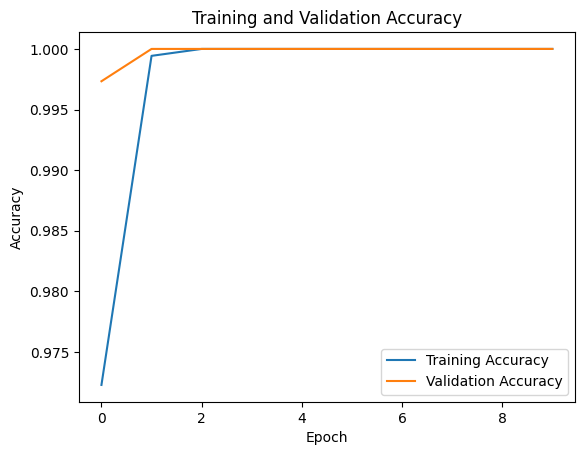

In [ ]:
# prompt: plot the training and validation accuracy

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


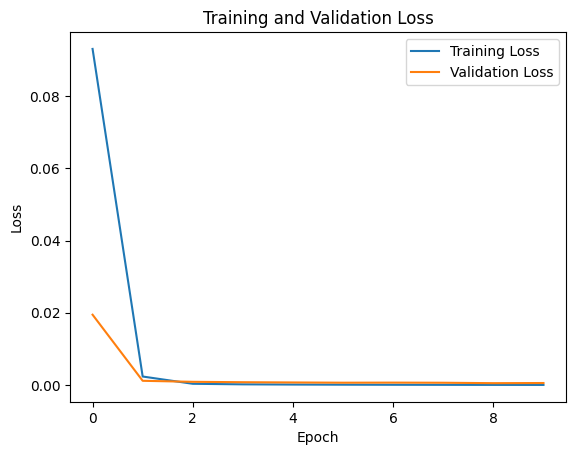

In [ ]:
# prompt: plot the training and validation loss

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step


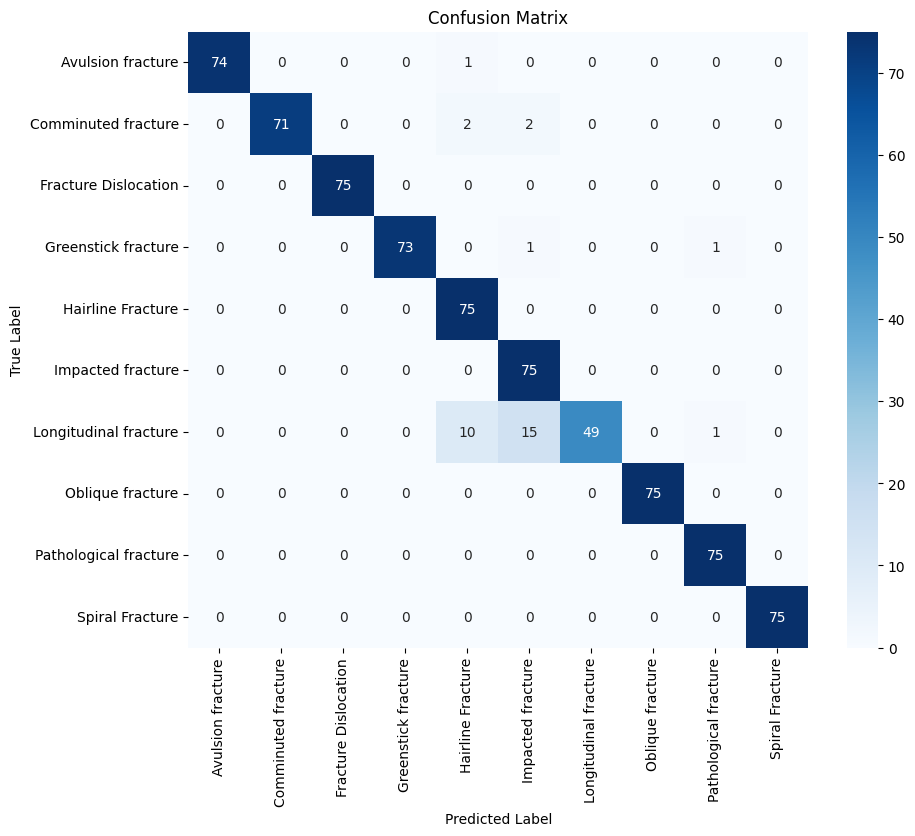

In [ ]:
# prompt: plot the confusion matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
